# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Reset the environment and initi the Agent

The next cell is to reset the environment to training mode, for faster learning. 
get the current states and initialize a score array. 

Also the agent class and some packages are loaded. 

In [5]:
env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)

In [6]:
from ddpg_agent import Agent
from collections import deque
from datetime import datetime
import torch

# Initialize Feed-forward DNNs for Actor and Critic models. 
agent = Agent(state_size = env_info.vector_observations.shape[1] , action_size = brain.vector_action_space_size ,random_seed=42)

# get some date and time for same names 
now = datetime.now()
d = now.strftime("%Y-%m-%d_%H-%M-%S")


### 4. Training the Agents

The Agents will be trained over episodes and each episode has a limited maximum time. The max time is needed to not get stuck in  one episode if break condition is not reached. 

In [8]:

import torch
import numpy as np
from collections import deque
from unityagents import UnityEnvironment
from ddpg_agent import Agent


def train_ddpg(n_episodes=1000, max_t=1000, solved_score=31.0, score_episodes=100,  train_mode=True):
    """ DDPG - Deep Deterministic Policy Gradient
    Train a reinforcement agent  (s) over n episodes 
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        train_mode (bool)     : if 'True' set environment to training mode
        solved_score (float)  : minimum average score over 'score_episodes' to solve the environment
        score_episodes  (int) : number of episodes the agents must reach minimum score to solve environment

    """
    
    actor_weights ='trained_agent/actor_weights.pth'
    critic_weights ='trained_agent/critic_weights.pth'
    
    mean_scores = []                               # mean scores from each episode
    min_scores = []                                # lowest scores from each episode
    max_scores = []                                # highest scores from each episode
    best_score = -np.inf
    scores_window = deque(maxlen=score_episodes )  # deque of mean scores over last score_episodes
    moving_avgs = []                               # moving average to solve env
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset environment
        states = env_info.vector_observations                   # get current state for each agent      
        scores = np.zeros(num_agents)                           # initialize score for each agent
        agent.reset()

        for t in range(max_t):
            # loop ovrt  t_max timesteps
            actions = agent.act(states, add_noise=True)         # select an action
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get next state
            rewards = env_info.rewards                          # get reward
            dones = env_info.local_done                         # see if episode has finished
            
            # save experience to replay buffer, perform learning step at defined interval
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)
            states = next_states
            scores += rewards        
            if np.any(dones):                                   # exit loop when episode ends
                break

        min_scores.append(np.min(scores))             # min score over all agents
        max_scores.append(np.max(scores))             # max score  over all agents 
        mean_scores.append(np.mean(scores))           # mean score  over all agents for the episode
        scores_window.append(mean_scores[-1])         # mean score to window
        moving_avgs.append(np.mean(scores_window))    # moving average

        
        print('\rEpisode {}  -- \tmin: {:.1f}\tmax: {:.1f}\tmean: {:.1f}\tmov. avg: {:.1f}'.format(\
            i_episode,  min_scores[-1], max_scores[-1], mean_scores[-1], moving_avgs[-1]))
        
        if train_mode and mean_scores[-1] > best_score:
            torch.save(agent.actor_local.state_dict(), actor_weights)
            torch.save(agent.critic_local.state_dict(), critic_weights)
                  
        if moving_avgs[-1] >= solved_score and i_episode >= score_episodes :
            print('\nEnvironment SOLVED in {} episodes!\tmov avg ={:.1f} over last {} episodes'.format(\
                                    i_episode-score_episodes , moving_avgs[-1], score_episodes ))            
            if train_mode:
                torch.save(agent.actor_local.state_dict(), 'checkpoint_'+d+'_actor_Solved.pth')
                torch.save(agent.critic_local.state_dict(), 'checkpoint_'+d+'_critic_Solved.pth') 
            break
            
    return mean_scores, moving_avgs





In [9]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    

agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)
scores, avgs = train_ddpg()

C:\Users\Token\miniconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 1  -- 	min: 0.0	max: 0.6	mean: 0.1	mov. avg: 0.1
Episode 2  -- 	min: 0.3	max: 1.5	mean: 0.8	mov. avg: 0.4
Episode 3  -- 	min: 0.2	max: 1.8	mean: 0.9	mov. avg: 0.6
Episode 4  -- 	min: 0.3	max: 2.4	mean: 1.1	mov. avg: 0.7
Episode 5  -- 	min: 0.7	max: 4.8	mean: 2.0	mov. avg: 1.0
Episode 6  -- 	min: 1.1	max: 4.3	mean: 2.5	mov. avg: 1.2
Episode 7  -- 	min: 0.6	max: 4.3	mean: 2.3	mov. avg: 1.4
Episode 8  -- 	min: 1.8	max: 5.8	mean: 3.0	mov. avg: 1.6
Episode 9  -- 	min: 0.9	max: 4.9	mean: 2.9	mov. avg: 1.7
Episode 10  -- 	min: 1.4	max: 6.5	mean: 3.5	mov. avg: 1.9
Episode 11  -- 	min: 1.7	max: 7.2	mean: 4.2	mov. avg: 2.1
Episode 12  -- 	min: 1.9	max: 6.3	mean: 3.7	mov. avg: 2.2
Episode 13  -- 	min: 1.7	max: 8.5	mean: 5.0	mov. avg: 2.5
Episode 14  -- 	min: 2.3	max: 7.4	mean: 4.7	mov. avg: 2.6
Episode 15  -- 	min: 1.9	max: 10.7	mean: 5.4	mov. avg: 2.8
Episode 16  -- 	min: 2.4	max: 11.1	mean: 5.9	mov. avg: 3.0
Episode 17  -- 	min: 3.4	max: 10.5	mean: 6.6	mov. avg: 3.2
Episode 18  -- 	min:

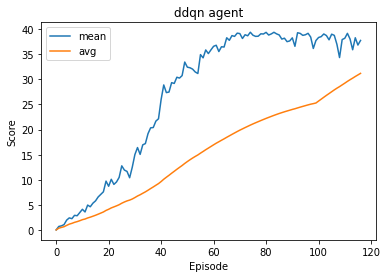

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(avgs)), avgs)
plt.title('ddqn agent')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.legend(['mean','avg'])
plt.show()


### Result

An Deep Actor-Critic Model with Deterministic Policy Gradient was used to solve the environment. 

In [24]:
from IPython.display import Video

Video("plots/double-jointed-arm.mp4", width=600)